# Convolutional autoencoder with Pytorch

In [1]:
import torch
import pickle
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch.nn.functional as inter
import torchvision.models as models
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff


import os
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import des données du problème**

torch.Size([7, 1, 100, 100])


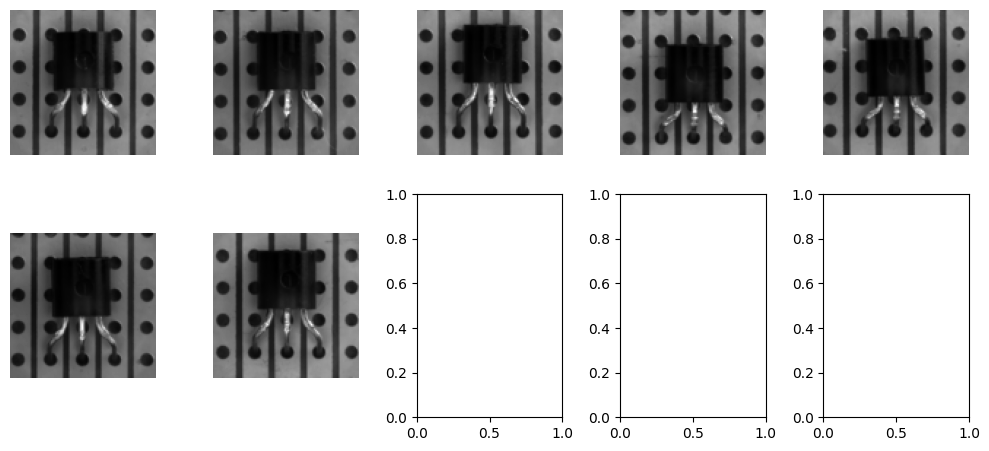

In [11]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image_rgb = Image.open(img_path)
        img_tensor = F.to_tensor(image_rgb)
        img_tensor_grey = F.rgb_to_grayscale(img_tensor, num_output_channels=1)
        img_resize = F.resize(img_tensor_grey, (100, 100))

        return img_resize

# Définir les répertoires de train et test
train_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/train/good'
test_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/good'
test_cut_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/cut_lead'
test_bent_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/bent_lead'
test_damaged_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/damaged_case'
test_misplaced_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/misplaced'

# Créer les datasets
train_dataset = CustomDataset(train_dir)
test_dataset = CustomDataset(test_dir)
test_cut_dataset = CustomDataset(test_cut_dir)
test_bent_dataset = CustomDataset(test_bent_dir)
test_damaged_dataset = CustomDataset(test_damaged_dir)
test_misplaced_dataset = CustomDataset(test_misplaced_dir)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=7, shuffle=True)

for batch_idx, image in enumerate(train_loader):

        # Reshaping the image to (-1, 64*64)
        # plt.imshow(image.detach().numpy().reshape(64,64))
        #image = image.view(-1, 64*64)  # Utiliser .view() au lieu de .reshape()
        print(image.size())

        fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Créer une grille de 2x5
        axes = axes.flatten()  # Rendre les axes 2D en 1D pour les parcourir facilement

        for i in range(7):
          axes[i].imshow(image[i].reshape(100,100), cmap='gray')  # Afficher l'image i en niveaux de gris
          axes[i].axis('off')  # Supprimer les axes pour une meilleure visibilité

        plt.tight_layout()
        plt.show()
        break

# **Classes permettant l'optimisation et la création de modèles**

Epoch 1/10, Loss: 0.0249
Epoch 2/10, Loss: 0.0071
Epoch 3/10, Loss: 0.0066
Epoch 4/10, Loss: 0.0065
Epoch 5/10, Loss: 0.0063
Epoch 6/10, Loss: 0.0061
Epoch 7/10, Loss: 0.0054
Epoch 8/10, Loss: 0.0047
Epoch 9/10, Loss: 0.0041
Epoch 10/10, Loss: 0.0036


IndexError: index 7 is out of bounds for dimension 0 with size 7

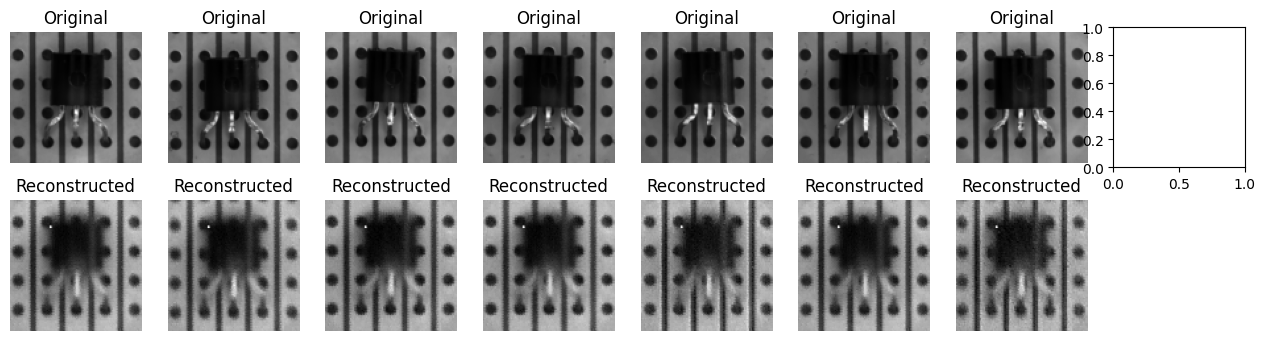

In [13]:
import torch.nn as nn
import torch.optim as optim
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encodeur
        self.encoder = nn.Sequential(

            nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder2 = nn.Sequential(
            nn.Linear(20*25*25, 25),
            nn.ReLU(),
        )

        self.decoder2 = nn.Sequential(
            nn.Linear(25, 20*100*100),
            nn.ReLU(),
        )


        # Décodeur
        self.decoder = nn.Sequential(
            nn.Conv2d(20, 10, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(10, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded2 = encoded.view(encoded.size(0), -1)  # Flatten the encoded tensor
        encoded2 = self.encoder2(encoded2)
        decoded2 = self.decoder2(encoded2)
        decoded2 = decoded2.view(decoded2.size(0), 20, 100, 100)
        decoded = self.decoder(decoded2)
        return decoded

# Initialiser le modèle
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images in train_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, num_epochs=10)


def plot_results(model, test_loader, n=7):
    model.eval()
    dataiter = iter(test_loader)
    images = next(dataiter)
    outputs = model(images)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Images originales
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Images reconstruites
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs[i].detach().squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

test_loader = DataLoader(test_dataset, batch_size=7, shuffle=True)
plot_results(model, test_loader)


In [14]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.0034
Epoch 2/10, Loss: 0.0031
Epoch 3/10, Loss: 0.0028
Epoch 4/10, Loss: 0.0026
Epoch 5/10, Loss: 0.0024
Epoch 6/10, Loss: 0.0024
Epoch 7/10, Loss: 0.0023
Epoch 8/10, Loss: 0.0022
Epoch 9/10, Loss: 0.0022
Epoch 10/10, Loss: 0.0021


In [20]:
train_model(model, train_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15, Loss: 0.0012
Epoch 2/15, Loss: 0.0012
Epoch 3/15, Loss: 0.0012
Epoch 4/15, Loss: 0.0012
Epoch 5/15, Loss: 0.0012
Epoch 6/15, Loss: 0.0011
Epoch 7/15, Loss: 0.0011
Epoch 8/15, Loss: 0.0011
Epoch 9/15, Loss: 0.0011
Epoch 10/15, Loss: 0.0011
Epoch 11/15, Loss: 0.0011
Epoch 12/15, Loss: 0.0010
Epoch 13/15, Loss: 0.0011
Epoch 14/15, Loss: 0.0011
Epoch 15/15, Loss: 0.0010


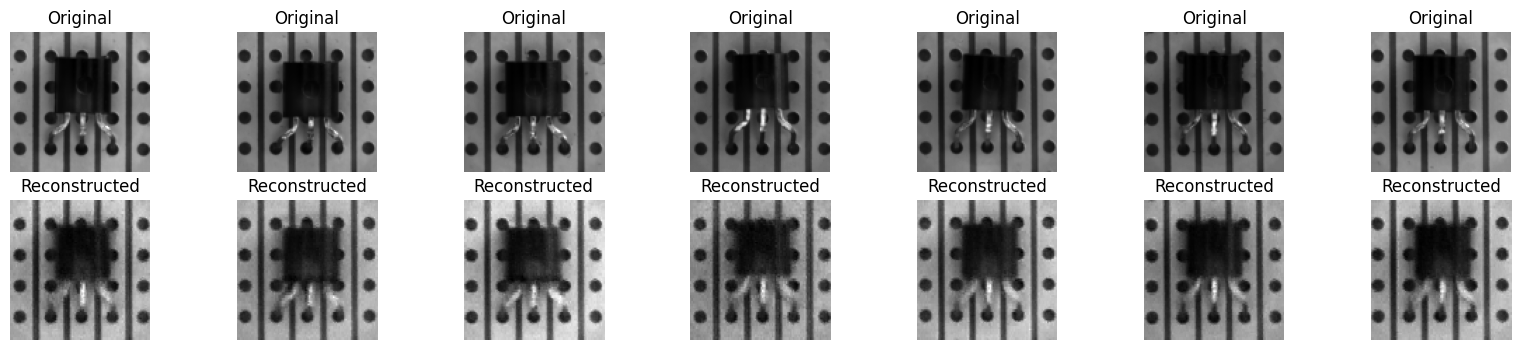

In [21]:
plot_results(model, test_loader, n=7)

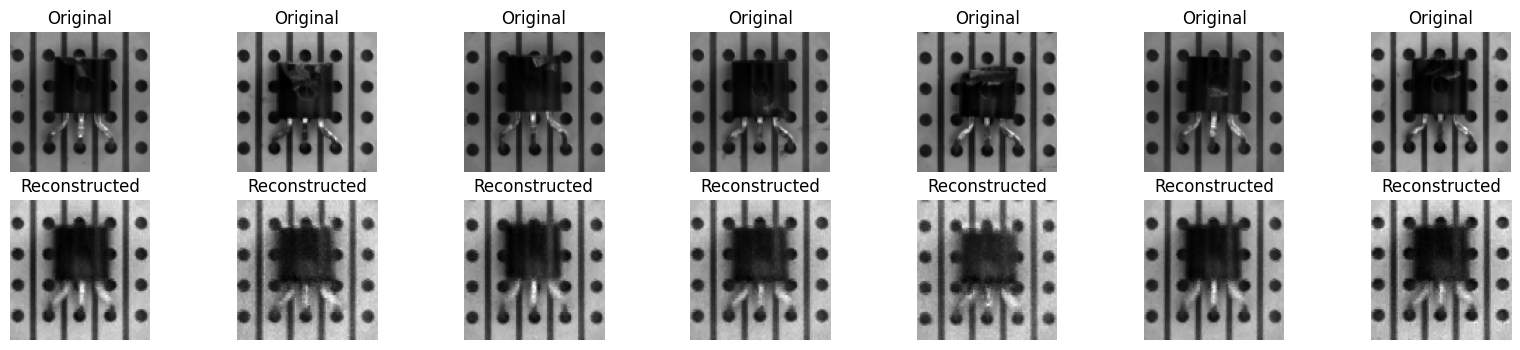

In [22]:
test_loader = DataLoader(test_dataset, batch_size=7, shuffle=True)
test_damaged_loader = DataLoader(test_damaged_dataset, batch_size=7, shuffle=True)
plot_results(model, test_damaged_loader, n=7)

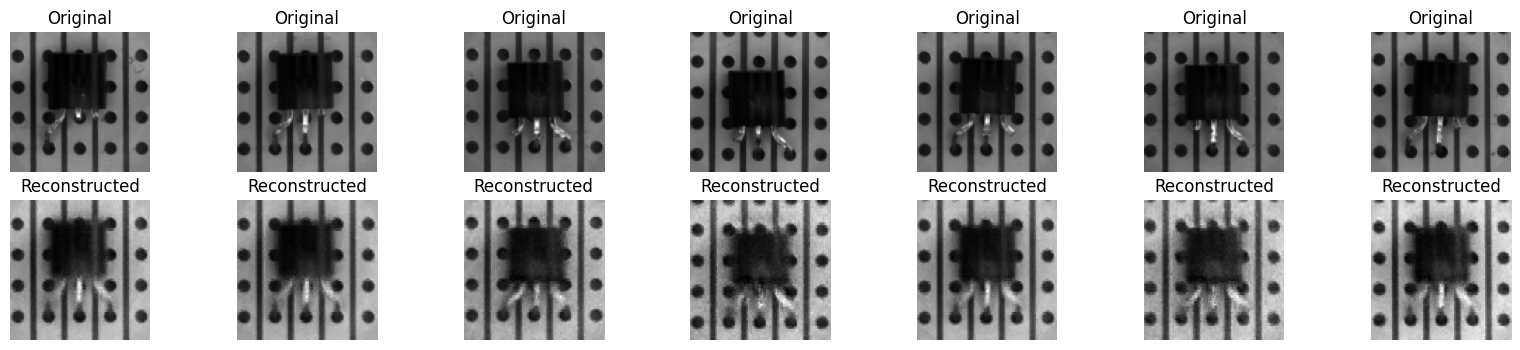

In [33]:
test_cut_loader = DataLoader(test_cut_dataset, batch_size=7, shuffle=True)
plot_results(model, test_cut_loader, n=7)

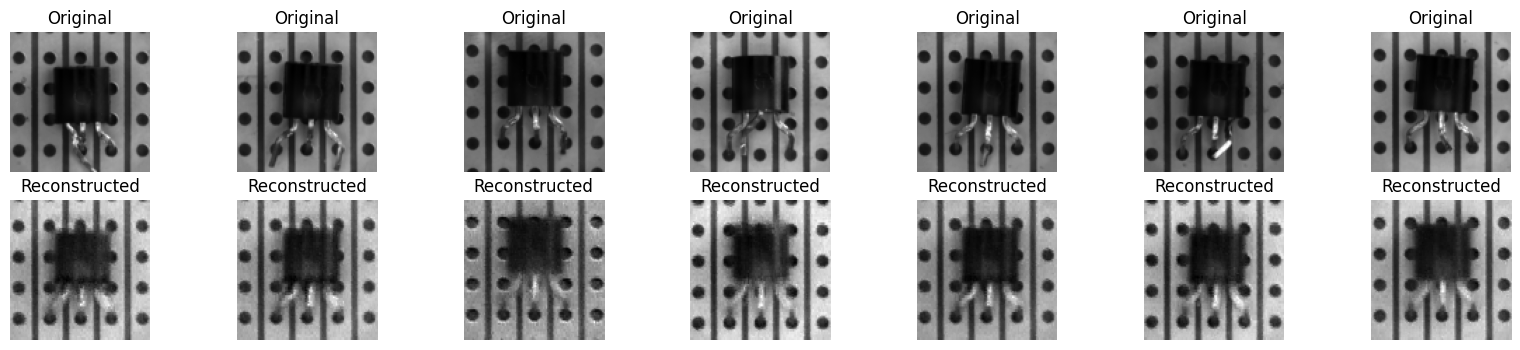

In [34]:
test_bent_loader = DataLoader(test_bent_dataset, batch_size=7, shuffle=True)
plot_results(model, test_bent_loader, n=7)

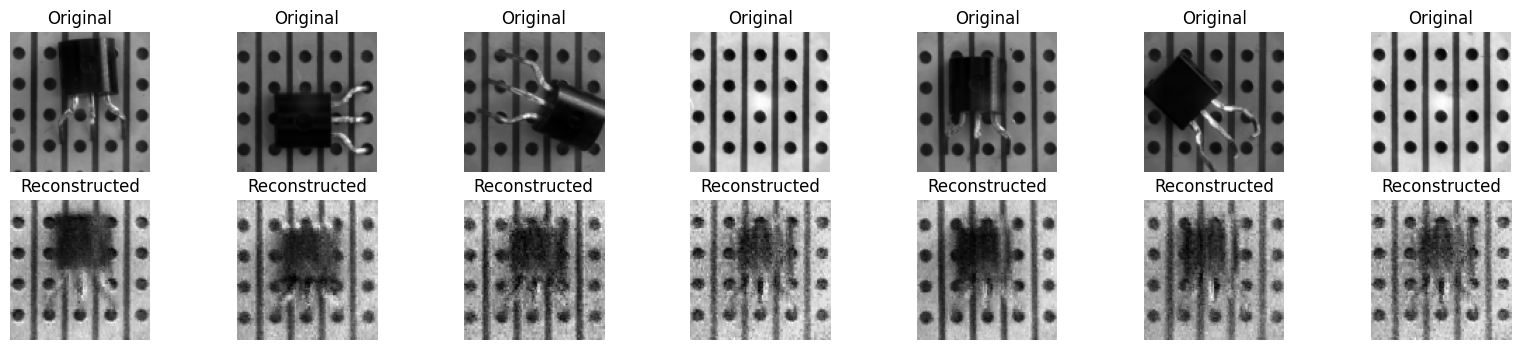

In [35]:
test_misplaced_loader = DataLoader(test_misplaced_dataset, batch_size=7, shuffle=True)
plot_results(model, test_misplaced_loader, n=7)

*texte en italique*# **Classes qui permettent l'évaluation des modèles**

In [23]:
test_cut_loader = DataLoader(test_cut_dataset, batch_size=len(test_cut_dataset))
test_bent_loader = DataLoader(test_bent_dataset, batch_size=len(test_bent_dataset))
test_damaged_loader = DataLoader(test_damaged_dataset, batch_size=len(test_damaged_dataset))
test_misplaced_loader = DataLoader(test_misplaced_dataset, batch_size=len(test_misplaced_dataset))
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [24]:
def loss_results(model, test_loader):
    model.eval()
    dataiter = iter(test_loader)
    images = next(dataiter)
    outputs = model(images)
    loss_list=[]
    for i in range(len(test_loader.dataset)):
        loss_i = criterion(images[i].squeeze(),outputs[i].detach().squeeze())
        loss_list.append(loss_i.item())
    return loss_list


In [25]:
loss_good = loss_results(model, train_loader)
loss_bent = loss_results(model, test_bent_loader)
loss_cut = loss_results(model, test_cut_loader)
loss_damaged = loss_results(model, test_damaged_loader)
loss_misplaced = loss_results(model, test_misplaced_loader)
loss_norm = loss_results(model, test_loader)
paire_good = []
paire_bent = []
paire_cut = []
paire_damaged = []
paire_misplaced = []
paire_norm = []

for i in range(len(loss_good)):
  paire_good.append([loss_good[i], 1])
for i in range(len(loss_bent)):
  paire_bent.append([loss_bent[i], -1])
for i in range(len(loss_cut)):
  paire_cut.append([loss_cut[i], -1])
for i in range(len(loss_damaged)):
  paire_damaged.append([loss_damaged[i], -1])
for i in range(len(loss_misplaced)):
  paire_misplaced.append([loss_misplaced[i], -1])
for i in range(len(loss_norm)):
  paire_norm.append([loss_norm[i], 1])

In [26]:
with open('/content/drive/MyDrive/EA_MAP/downloaded_data/conv_autoencoder/model_50epochs_loss0.001.pkl', 'wb') as file:
  pickle.dump(model, file)


In [27]:
name = 'conv_autoencoder/test_batchsize=7/epochs=50'
folder_path = f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name}'
os.makedirs(folder_path, exist_ok=True)
with open(f'{folder_path}/paire_good.pkl', 'wb') as file:
  pickle.dump(paire_good, file)
with open(f'{folder_path}/paire_bent.pkl', 'wb') as file:
  pickle.dump(paire_bent, file)
with open(f'{folder_path}/paire_misplaced.pkl', 'wb') as file:
  pickle.dump(paire_misplaced, file)
with open(f'{folder_path}/paire_cut.pkl', 'wb') as file:
  pickle.dump(paire_cut, file)
with open(f'{folder_path}/paire_damaged.pkl', 'wb') as file:
  pickle.dump(paire_damaged, file)
with open(f'{folder_path}/paire_norm.pkl', 'wb') as file:
  pickle.dump(paire_norm, file)

## Tests

In [28]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.5 MB/s eta 0:00:00


In [29]:
def show_box_chart(title, name_folder, list):  # renvoie boîtes à moustache, liste des loss que l'on veut considérer, mettre loss du training set en premier (bleu)
  fig = go.Figure()
  fig.add_trace(go.Box(
        y=list[0][:,0],
        name=f'Loss from training set',
        marker_color='blue'
    ))

  for k in range(1, len(list)):
    fig.add_trace(go.Box(
        y=list[k][:,0],
        name=f'Loss {k}',
        marker_color='red'
    ))


  # Mettre à jour la disposition pour les afficher l'une en dessous de l'autre
  fig.update_layout(
      title=f'{title}',
      yaxis_title='Valeurs de perte',
      boxmode='group',  # Afficher les boxplots l'un en dessous de l'autre
      showlegend=True
  )
  pio.write_image(fig, f'/content/drive/MyDrive/EA_MAP/downloaded_data/{name_folder}/boxplot.png')
  fig.show()

In [30]:
show_box_chart('conv_autoencoder', 'conv_autoencoder/test_batchsize=7/epochs=50', [np.array(paire_norm), np.array(paire_good), np.array(paire_cut), np.array(paire_damaged), np.array(paire_bent), np.array(paire_misplaced)])

In [31]:
n_front = 30000

map_boundaries = [i/n_front for i in range(n_front+1)]

def evaluation_boundary(paires, map_boundary):
  evaluation = []
  for i in range(len(paires)):
    evaluation.append(((2*int(paires[i][0] < map_boundary) - 1)*paires[i][1]+1)/2) # paires : liste avec toutes les paires évaluées par rapport a map_boundary
  return evaluation


def evaluate_whole_testset(list): # liste des paires
  percent_an = []
  percent_good = []
  for boundary in map_boundaries:
    percent_evaluation_good = np.sum(evaluation_boundary(list[1], boundary))/len(list[1])
    percent_evaluation_an = np.sum(evaluation_boundary(np.concatenate([list[2],list[3],list[4],list[5]]), boundary))/len(np.concatenate([list[2],list[3],list[4],list[5]]))
    percent_good.append([percent_evaluation_good,boundary])
    percent_an.append([percent_evaluation_an,boundary])
  return percent_good, percent_an


def plot_ROC(list):
  percent_good, percent_an = evaluate_whole_testset(list)
  plt.plot(np.ones(len(percent_an))-np.array([i[0] for i in percent_an]), np.array([i[0] for i in percent_good]), label='ROC curve')
  plt.title('ROC curve')
  plt.xlabel('false positives')
  plt.ylabel('true positives')
  plt.grid()
  plt.legend()
  plt.text(0.5, 0.15, f"AUC : {AUC(list)}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=12)


def AUC(list):
  percent_good, percent_an = evaluate_whole_testset(list)
  auc = 1 - np.trapz(np.ones(len(percent_an))-np.array([i[0] for i in percent_an]), np.array([i[0] for i in percent_good]))
  return auc

def AUC_30(list):
  percent_good, percent_an = evaluate_whole_testset(list)
  perc = []
  print(percent_an[7])
  for i in range(len(percent_an)):
    if 1-percent_an[i][0] < 0.3:
      perc.append(percent_an[i])
  percent_an = perc
  print(percent_an)
  percent_good = percent_good[0:len(percent_an)]
  tab1 = np.ones(len(percent_an))-np.array([i[0] for i in percent_an])
  tab2 = np.array([i[0] for i in percent_good])
  tab1 = [tab1[i] for i in range(len(tab1))]
  tab2 = [tab2[i] for i in range(len(tab2))]
  tab1.append(0.30)
  tab2.append(tab2[-1]+0.1)
  auc = (0.3 - np.trapz(tab1, tab2))/0.3 *0.8
  plt.plot(tab1, tab2)
  plt.grid()
  plt.show()
  return auc


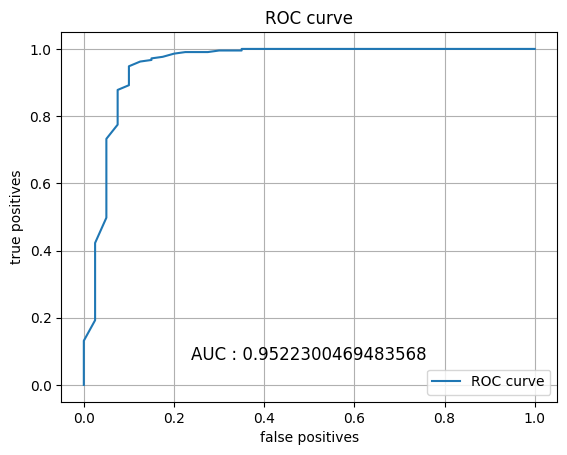

In [32]:
plot_ROC([paire_norm, paire_good, paire_cut, paire_damaged, paire_bent, paire_misplaced])